# IDL Homework 2

Mikko Saukkoriipi, Sebastian Lampinen & Ville Kopio

## Regularization

This model uses Gaussian noise, early stopping and dropout. Random erasing of image data was also tested but due to the images being low resolution it only affected negatively to the results.

## Optimization

We tested three different optimization techniques:

- Stochastic gradient decent (torch.optim.SGD)
- Adam (torch.optim.Adam)
- Sparse Adam (torch.optim.SparseAdam)

Adam was chosen as the optimizer.

## Test accuracy

Test accuracy of over 92.65 % was reached as shown in the cells bellow.

In [16]:
import torch
import torch.optim as optim
import torch.utils.data
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import transforms, datasets, models
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
import statistics

#--- hyperparameters ---
N_EPOCHS = 10
BATCH_SIZE = 100
LR = 0.0001

#--- fixed constants ---
NUM_CLASSES = 24
DATA_DIR = '../data/sign_mnist_%s'

In [17]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


def load_dataset(dataset_name, shuffle=False, extra_transforms=[]):
    common_transforms = [
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.5, std=0.5, inplace=True)
    ]

    dataset = datasets.ImageFolder(
        DATA_DIR % dataset_name,
        transform=transforms.Compose(common_transforms + extra_transforms)
    )

    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=BATCH_SIZE,
        shuffle=shuffle
    )

    return data_loader

train_loader = load_dataset('train', shuffle=True, extra_transforms=[AddGaussianNoise(0.1, 0.1),])
dev_loader = load_dataset('dev')
test_loader = load_dataset('test')

In [18]:
#--- model ---
class CNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(CNN, self).__init__()
        
        # Sequential 1: Convolution + batch normalization + ReLU + maxpooling
        self.seq1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=28, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=28),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
        
        # Sequential 2: Convolution + batch normalization + ReLU + maxpooling
        self.seq2 = nn.Sequential(
            nn.Conv2d(in_channels=28, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Dropout(p=0.1))
        
        # Sequential 3: Linear + ReLU + Linear
        self.seq3 = nn.Sequential(
            nn.Linear(in_features=3136, out_features=512),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=NUM_CLASSES))
            
    def forward(self, x):
        x = self.seq1(x)
        x = self.seq2(x)
        x = x.view(x.size(0), -1)
        x = self.seq3(x)
        x = F.log_softmax(x, dim=1)
        
        return x

In [19]:
#--- set up ---
print("Cuda is available: {} \n".format(torch.cuda.is_available()))

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

model = CNN().to(device)

optimizer = torch.optim.SparseAdam(model.parameters(), lr=LR)

loss_function = nn.CrossEntropyLoss()

# Early stopping parameters initialization
# Make empty dev lost list and add start values 0 to list
# When done=True, then end training
dev_loss_list = []
train_loss_list = []
dev_loss_list.append(100)
dev_loss_list.append(100)
dev_loss_list.append(100)
done = False
counter = 1

Cuda is available: False 



ValueError: optimizer got an empty parameter list

Epoch 1 | training acc 0.8192, loss 0.7613 | dev acc 0.8574, loss 0.5119
Epoch 2 | training acc 0.9924, loss 0.0751 | dev acc 0.9026, loss 0.3711
Epoch 3 | training acc 0.9986, loss 0.0271 | dev acc 0.9106, loss 0.3497
Epoch 4 | training acc 0.9993, loss 0.0141 | dev acc 0.9177, loss 0.3492
Epoch 5 | training acc 0.9995, loss 0.0089 | dev acc 0.9160, loss 0.3383
Epoch 6 | training acc 0.9999, loss 0.0057 | dev acc 0.9209, loss 0.3374
Epoch 7 | training acc 0.9998, loss 0.0046 | dev acc 0.9177, loss 0.3365
Epoch 8 | training acc 0.9999, loss 0.0034 | dev acc 0.9220, loss 0.3507
Dev accuracy declining. Activate early stopping. 



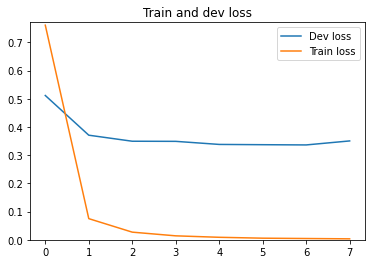

In [10]:
#--- training ---
for epoch in range(N_EPOCHS):
    if done:
        break

    train_loss = 0
    train_correct = 0
    total = len(train_loader.dataset)
    
    for batch_num, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        
        train_correct += (predicted == target).sum().item()
        loss = loss_function(outputs, target)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss

        print('Epoch %d | batch %d %% done' % (epoch + 1, 100 * (batch_num + 1) / len(train_loader),), end="\r")

    train_loss_list.append(float(train_loss / len(train_loader)))

    # -- Check development set accuracy and stop training if it start to decline
    dev_loss = 0
    dev_correct = 0
    total = 0
    for dev_batch_num, (dev_data, dev_target) in enumerate(dev_loader):
        dev_data, dev_target = dev_data.to(device), dev_target.to(device)

        dev_outputs = model(dev_data)
        _, dev_predicted = torch.max(dev_outputs, 1)

        dev_correct += (dev_predicted == dev_target).sum().item()
        dev_loss += loss_function(dev_outputs, dev_target)
    
    dev_loss = dev_loss / len(dev_loader)
    
    # Save dev loss to list
    dev_loss_list.append(dev_loss)

    print('Epoch %d | training acc %.4f, loss %.4f | dev acc %.4f, loss %.4f' %
            (epoch + 1,
            train_correct / len(train_loader.dataset),
            train_loss / len(train_loader),
            dev_correct / len(dev_loader.dataset),
            dev_loss))


    # If the latest dev correct accuracy is smaller than the last 3 values, then end training
    dev_last_three = dev_loss_list[-4:-1]
    if dev_loss > max(dev_last_three):
        print("Dev accuracy declining. Activate early stopping. \n")
        done = True
        break

# Remove initialized first three values from dev_correct_list
dev_loss_list = dev_loss_list[3:]

# Plot dev correct
plt.plot(dev_loss_list, label = "Dev loss")
plt.plot(train_loss_list, label = "Train loss")
plt.ylim((0, max(dev_loss_list+train_loss_list)+0.01))
plt.title("Train and dev loss")
plt.legend()
plt.show()

In [11]:
#--- test ---
test_loss = 0
test_correct = 0
total = 0

with torch.no_grad():
    for batch_num, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)

        outputs=model(data)
        _, predicted = torch.max(outputs.data, 1)

        total += target.size(0)
        test_correct += (predicted == target).sum()
        loss = loss_function(outputs, target)
        test_loss += loss

print("\nTest accuracy %.2f %%" % (100. * test_correct / total))


Test accuracy 92.65 %
